Total runtime: 132.54667111299932 seconds


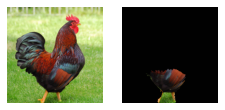

In [1]:
# from lowba_custom import lowbaAXAI
from bbattack import lowbaAXAI
from AXAIbb_pipeline import AXAI_BB
import numpy as np
import matplotlib.pyplot as plt
import json
from timeit import default_timer as timer
import torchvision.models as models
import torch
import torchvision.transforms as transforms
import copy
import os
from PIL import Image

def rle_encode_mask(mask):
    mask = np.array(mask, dtype=np.bool_, copy=False)
    curr = 0
    count = 0
    counts = []
    for x in np.nditer(mask, order='F'):
        if x != curr:
            counts.append(count)
            count = 0
            curr = x
        count += 1
    counts.append(count)
    return counts

def rle_decode_mask(rle_mask, width, height):
    from itertools import cycle, repeat
    generator = cycle([0, 1])
    mask = np.concatenate([list(repeat(y, x)) for x, y in zip(rle_mask, generator)])
    mask = np.reshape(mask, newshape=(width, height), order="F")
    return mask



# load imputs, labels, models
img_path = 'imgcls_sample/input/ILSVRC2012_val_00023551.JPEG'
# img_path = 'imgcls_sample/input/ILSVRC2012_val_00047112_org.png'
label_path = 'imgcls_sample/ImageNet_labels.json'
with open(label_path) as f:
    label_name = json.load(f)   
LABELS = {int(idx):label for idx, label in label_name.items()}

model = models.resnet34(pretrained=True)
if torch.cuda.is_available() is True:
    model.cuda()
model.eval()

# preprocessing input
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

preprocess = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.CenterCrop(224),
                transforms.ToTensor(),])
preprocess_n = transforms.Compose([transforms.Resize((256, 256)),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor()])
img = Image.open(img_path)
images = preprocess(img).unsqueeze(0)
data_org = preprocess_n(img).unsqueeze(0)
if torch.cuda.is_available():
    images = images.cuda()


#low frequency boundary attack
start = timer()
perturbed_image = lowbaAXAI(images,mean,std,model,
                            perturb_mode = 'dct',
                            dct_ratio = 1/32,
                            num_steps = 1000,
                            spherical_step = 0.10,
                            source_step = 0.01,
                            repeat_images = 1,
                            halve_every=250,
                            blended_noise = True,
                            batch_size = 1)

#AXAI pipeline
explaination_BB = AXAI_BB(inputs = data_org[0])
diff = (perturbed_image[0].cpu()-data_org[0].cpu()).squeeze(0).numpy()
Mask = explaination_BB.threshold(diff, percentage = 15)
explainations = explaination_BB.mapping2(Mask,data_org=data_org,
                                         K=1,
                                         kernel_size=8,
                                         max_dist=200,
                                         ratio=0.2)
end = timer()
print('Total runtime:',end - start, "seconds")

plt.rc('font', family='serif', serif='Times')
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
width = 3.487
height = width / 1.618
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(1,2,1) 
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
ax.imshow(np.transpose(data_org.squeeze().detach().cpu().numpy(), (1, 2, 0)))
ax.axis('off')
ax = plt.subplot(1,2,2) 
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
ax.imshow((explainations * 255).astype(np.uint8))
ax.axis('off')
fig.set_size_inches(width, height)
plt.show()

output_path = 'imgcls_sample/output/'
m = transforms.ToPILImage()((explainations * 255).astype(np.uint8)).convert("RGB")
m.save(os.path.join(output_path,'{}_exp_bb.png'.format(os.path.splitext(os.path.basename(img_path))[0])))



#mask transformation
explainations_tmp = copy.deepcopy(explainations)
explainations_tmp[explainations==255.0]=0
explainations_tmp[explainations!=255.0]=1
mask_axai = explainations_tmp[:,:,0]
rle_mask = rle_encode_mask(mask_axai)

#prediction outputs
if torch.cuda.is_available() is True:
    data_org = data_org.cuda()
pred=model(data_org)
softmax = torch.nn.Softmax(dim=1)
output = softmax.forward(pred)
hardlabel = output.argmax(dim=1).cpu()
softlabel = output[0][hardlabel].cpu()

# convert results into json
results = {
    'class': {
        'id': int(hardlabel),
        'label': LABELS[int(hardlabel)],
        'probability': float(softlabel),
    },
    'explanation': {
        'mask': rle_mask,
    }
}

output_json_path = 'imgcls_sample/output/'
out_name = os.path.splitext(os.path.basename(img_path))[0]+'_exp_bb'+'.json'
with open(os.path.join(output_path,out_name), 'w', encoding='utf-8') as output_file:
    json.dump(results, output_file)